# Прогнозирование: Покупки страховки на транспорт клиентом

## Чтение данных

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np          
import seaborn as sns         
import sklearn      

train_dataset = []
test_dataset = []
dataset = []

dataset = pd.read_csv("insurance/aug_train.csv", sep=',', encoding="Windows-1252")

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
categorical_ind = list(range(5,8)) + [1] + [3] + [11]
dataset.iloc[:,categorical_ind]=dataset.iloc[:,categorical_ind].astype('category')
categorical_columns = [c for c in dataset.columns if dataset[c].dtype.name == 'category']
numerical_columns   = [c for c in dataset.columns if dataset[c].dtype.name != 'category']

data_describe = dataset.describe(include = ['category'])
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]

data_nonbinary = pd.get_dummies(dataset[nonbinary_columns])

for col_num in binary_columns:
    dataset[col_num] = dataset[col_num].astype(object)

dataset.at[dataset['Gender'] == 'Male', 'Gender'] = 0
dataset.at[dataset['Gender'] == 'Female', 'Gender'] = 1

dataset.at[dataset['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0
dataset.at[dataset['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1

for col_num in binary_columns:
    dataset[col_num] = dataset[col_num].astype('category')
    
data_numerical = dataset[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [36]:
data = pd.concat((data_numerical, data_nonbinary, dataset[binary_columns]), axis = 1)

In [37]:
X = data.drop('Response', axis = 1)
y = data['Response']

## Разбиваем данные на тренировочную и тестовую выборку

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(286615, 95539)

## Обучение классификатора

In [39]:
from sklearn.neural_network import MLPClassifier

In [41]:
mlp_model = MLPClassifier(hidden_layer_sizes = (2,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42,
                         max_iter=2000)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(2,), max_iter=2000,
              random_state=42, solver='lbfgs')

In [42]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

Ошибка на обучаеющей и тестовой выборках

In [43]:
err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)
print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.10202187603579715
Ошибка на тестовой выборке:  0.10239797360240321


## Зависимость ошибки от параметра alpha

In [45]:
from sklearn.metrics import accuracy_score
alpha_arr = np.logspace(-2, 19, 21)
err_train = []
err_test = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (2,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42,
                          max_iter=2000,
                          alpha = alpha)
    mlp_model.fit(X_train, y_train)
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    err_train.append(np.mean(y_train != y_train_pred))
    err_test.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))


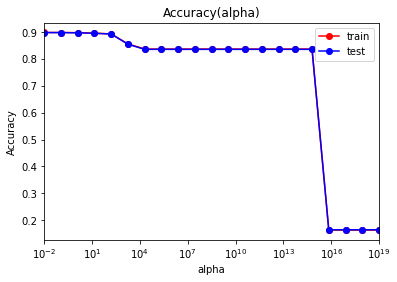

In [53]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy(alpha)')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

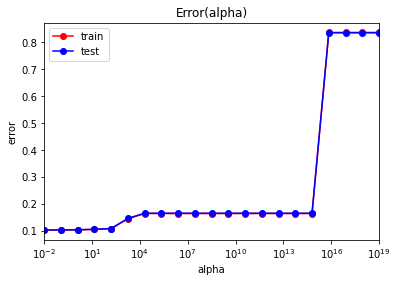

In [52]:
plt.semilogx(alpha_arr, err_train, 'r-o', label = 'train')
plt.semilogx(alpha_arr, err_test, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error(alpha)')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

In [54]:
min_err_train = np.min(err_train)
min_err_test = np.min(err_test)
print(min_err_train, min_err_test)

0.1019625630200792 0.10241890746187421


In [55]:
alpha_opt = alpha_arr[err_test == min_err_test]
print(alpha_opt)

[0.01]


***Классификатор при оптимальном значении alpha***

In [57]:
mlp_model = MLPClassifier(hidden_layer_sizes = (2,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42,
                          max_iter=2000,
                          alpha = alpha_opt)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)
print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.1019625630200792
Ошибка на тестовой выборке:  0.10241890746187421


## Зависимость ошибки от количества нейронов

In [59]:
neuron_numbers = np.array([1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40])
err_train = []
err_test = []
for neuron_number in neuron_numbers:
    mlp_model = MLPClassifier(hidden_layer_sizes = (2, neuron_number),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42,
                          max_iter=2000,
                          alpha = alpha_opt)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    err_train.append(np.mean(y_train != y_train_pred))
    err_test.append(np.mean(y_test != y_test_pred))

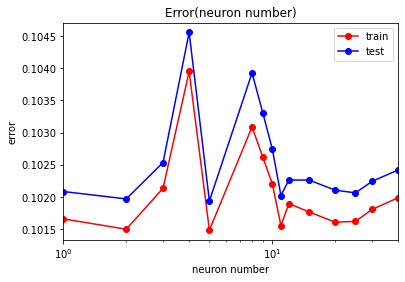

In [60]:
plt.semilogx(neuron_numbers, err_train, 'r-o', label = 'train')
plt.semilogx(neuron_numbers, err_test, 'b-o', label = 'test')
plt.xlim([np.min(neuron_numbers), np.max(neuron_numbers)])

plt.title('Error(neuron number)')
plt.xlabel('neuron number')
plt.ylabel('error')
plt.legend()
pass

*Исходя из графика, можно сказать, что при neuron number = 0, ..., 10 наблюдается значительное колебание величины ошибки (в некоторых случаях - недообучение). При увеличении числа нейронов ситуация "выравнивается"*

In [61]:
min_err_train = np.min(err_train)
min_err_test = np.min(err_test)
print(min_err_train, min_err_test)

0.10148456989341102 0.10193742869404118


In [63]:
neuron_number_opt = neuron_numbers[err_test == min_err_test]
print(neuron_number_opt)

[5]


Классификатор при оптимальном значении числа нейронов

In [64]:
mlp_model = MLPClassifier(hidden_layer_sizes = (2, neuron_number_opt[0]),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42,
                          max_iter=2000,
                          alpha = alpha_opt)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)
print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.10148456989341102
Ошибка на тестовой выборке:  0.10193742869404118


### Зависимость ошибки от количества слоев

In [ ]:
layer_numbers = np.array([2, 3, 4, 5, 7, 10, 30, 50])
test_err = []
train_err = []
for ln in layer_numbers:
    mlp_model = MLPClassifier(hidden_layer_sizes = (ln, neuron_number_opt[0]),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42,
                          max_iter=2000,
                          alpha = alpha_opt)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

In [ ]:
plt.semilogx(layer_numbers, train_err, 'r-o', label = 'train')
plt.semilogx(layer_numbers, test_err, 'b-o', label = 'test')
plt.xlim([np.min(layer_numbers), np.max(layer_numbers)])

plt.title('Error vs. layer_numbers')
plt.xlabel('layer_numbers')
plt.ylabel('error')
plt.legend()
pass

## Выводы

- Оптимальное количество слоев = 
- Оптимальное количество нейронов = 5
- Оптимальное alpha = 0.01